# Analysis - Congressional Fundraising and Votes

### Set-up

In [7]:
#import dependencies
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3 as lite
import sys

#plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
#import dataset
data = pd.read_csv('new data.csv')
data['vote'] = [0 for _ in range(len(data))]
data['party'] = [0 for _ in range(len(data))]
#remove candidates for which we have no fundrasing data
data = data[data['amount'] != '0']

#prepare for cleaning
a = np.array(data.as_matrix())
data[1:10]

,text,amount,vote,party
1,Candidate,Candidate Raised,0,0
2,Bradley Byrne (R) • Incumbent • Winner,1366370,0,0
3,Alabama District 02,NaN,0,0
4,Candidate,Candidate Raised,0,0
5,Martha Roby (R) • Incumbent • Winner,1381821,0,0
8,Alabama District 03,NaN,0,0
9,Candidate,Candidate Raised,0,0
10,Mike D Rogers (R) • Incumbent • Winner,1137285,0,0
11,Jesse Smith (D),9810,0,0


### Cleaning

#### Clean Fundraising Data

In [8]:
#trim candidate names
for i in range(len(a)):
    t = a[i][0].split(' (')
    a[i][0] = t[0]
    if len(t) > 1:
        a[i][3] = t[1].split(')')[0]

#split large dataset into small arrays by district
b = np.split(a, (a.transpose()[0] == 'Candidate').nonzero()[0] - 1)
#for i in range(len(b)):
#    b[i] = b[i][1:]
    #todo: add votes header
us_state_abbrev = { 'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
                   'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
                   'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
                   'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
                   'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
                   'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
                   'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
                   'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
                   'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
                   'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
                   'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
                   'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', }

#### Clean Voting Data

In [3]:
#read votes data
voting = pd.read_csv('voting2.csv')
v = voting.values
to_del = []
for i in  range(len(v)):
    v[i][0] = v[i][0].split(' (')
    if '%' in v[i][0][1]:
        t = v[i][0][1].split(') ')[1]
        vote = t[:t.index('%')]
        try:
            vote = float(vote)
            if vote < 5:
                to_del.append(i)
            v[i][0][1] = vote
        except ValueError:
            #delete rows for which we don't have vote data
            to_del.append(i)
    else:
        to_del.append(i)
v = np.delete(v, to_del, 0)
for i in range(len(a)):
    if a[i][3] == 0:
        j = 1
    elif a[i][3] == 'R':
        a[i][3] = 0.0
    elif a[i][3] == 'D':
        a[i][3] = 1.0
    else:
        a[i][3] = 0.5

#### Match Vote % to Candidates



In [4]:
#todo: make more efficient
for k in range(len(v)):
    for i in range(len(b)):
        if v[k][0][0] in b[i][:,0]:
            for j in range(len(b[i])):
                if v[k][0][0] in b[i][j]:
                    b[i][j][2] = v[k][0][1]

#### Example Chunk

In [5]:
df = pd.DataFrame(b[63])
df
#todo: convert headers

,0,1,2,3
0,California District 42,NaN,0,0
1,Candidate,Candidate Raised,0,0
2,Ken Calvert,1443899,58.8,0
3,Tim Sheridan,138396,41.2,1


### Calculations

#### Calculate % Raised for Each Candiate in Chunk



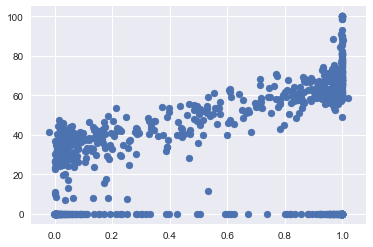

In [6]:
def calc(x):
    total = sum(x[2:][:,1].astype(int))
    names = x[2:][:,0].astype(str)
    spends = [i / total for i in x[2:][:,1].astype(int)]
    votes = x[2:][:,2].astype(float)
    #return list of lists: [% raised, % votes]
    i = [list(a) for a in zip(spends, votes, x[2:][:,3], names)]
    for j in i:
        j.append(total)
        #print(us_state_abbrev[x[0][0].split(' District ')[0]] + x[0][0].split(' District ')[1], j)
    return i

d = np.array([[0,0, 0, 0, 0]])
for i in range(1, len(b)):
    d = np.concatenate((d, calc(b[i])), axis = 0)
x, y, = d[:,0], d[:,1]
plt.scatter(x, y)